In [1]:
import pandas as pd
from freesurfer_stats import CorticalParcellationStats
import glob
import re
import itertools
import numpy as np
import pyls
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import pickle
from sklearn import preprocessing
from scipy.stats import zscore
from nilearn import input_data
from nilearn import plotting
import pingouin as pg

/opt/miniconda3/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
sns.set_context("notebook", font_scale=1.7)
sns.set_style("whitegrid")

/opt/miniconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/opt/miniconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Carga datos volúmenes

In [3]:
all_volumes_file = 'data/all_volumes.csv'
all_volumes = pd.read_csv(all_volumes_file)
all_volumes.drop(columns=all_volumes.columns[0], axis=1, inplace=True)
#all_volumes.columns.to_list()

# Selección de estructuras, no se inlcluye el 5to ventrículo
columns = list(range(0,15)) + list(range(21,54)) + list(range(61,467))
selected_values = all_volumes.iloc[:,columns]

# Cambio nombre grupo
selected_values.rename(columns={'grupo': 'group'}, inplace=True)

# Selección prisma 1
selected_values = selected_values.loc[selected_values['project'].isin(['prisma1','controles'])]

# Selección TAB y CTRL
selected_values = selected_values.loc[selected_values['group'].isin(['TAB','CTR'])]
#selected_values

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/1738174401.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_values.rename(columns={'grupo': 'group'}, inplace=True)


In [4]:
# Conteo datos iniciales
selected_values.groupby('group').describe()

Brain Segmentation Volume                                         \
                          count          mean            std       min   
group                                                                    
CTR                        40.0  1.095219e+06  114375.642017  919318.0   
TAB                        87.0  1.058379e+06  115520.861944  850640.0   

                                                   \
             25%        50%        75%        max   
group                                               
CTR    1036581.5  1074693.0  1137592.5  1497849.0   
TAB     973184.5  1049510.0  1141247.5  1324372.0   

      Brain Segmentation Volume Without Ventricles                ...  \
                                             count          mean  ...   
group                                                             ...   
CTR                                           40.0  1.076981e+06  ...   
TAB                                           87.0  1.034507e+06  ...   

      17Networks_RH_TempPar_9         17Networks_RH_TempPar_10              \
                          75%     max                    count        mean   
group                                                                        
CTR                    765.75  1491.0                     40.0  902.375000   
TAB                    735.00  1467.0                     87.0  854.494253   

                                                        
              std    min     25%    50%    75%     max  
group                                                   
CTR    184.436451  549.0  807.25  904.0  971.5  1375.0  
TAB    208.654709  319.0  721.00  830.0  962.0  1452.0  

[2 rows x 3608 columns]

In [5]:
# Selección sujetos chequeo freesurfer
check_file = 'data/ConsolidadoRatings.xlsx'
check_data = pd.read_excel(check_file,'ALL')
suj_to_remove = check_data[check_data['Rating'] == 'FaIL'].Codigo

selected_values = selected_values.set_index('subject')
selected_values.drop(index=suj_to_remove,inplace=True)
selected_values = selected_values.reset_index(drop=False)
selected_values.groupby('group').describe()

Brain Segmentation Volume                                         \
                          count          mean            std       min   
group                                                                    
CTR                        32.0  1.105633e+06  113994.378721  923026.0   
TAB                        66.0  1.067572e+06  119389.639898  850640.0   

                                                    \
             25%        50%         75%        max   
group                                                
CTR    1042351.5  1083722.5  1137592.50  1497849.0   
TAB     974377.5  1051649.0  1154686.75  1324372.0   

      Brain Segmentation Volume Without Ventricles                ...  \
                                             count          mean  ...   
group                                                             ...   
CTR                                           32.0  1.087699e+06  ...   
TAB                                           66.0  1.043146e+06  ...   

      17Networks_RH_TempPar_9         17Networks_RH_TempPar_10             \
                          75%     max                    count       mean   
group                                                                       
CTR                    765.75  1491.0                     32.0  887.96875   
TAB                    760.50  1467.0                     66.0  860.69697   

                                                        
              std    min     25%    50%    75%     max  
group                                                   
CTR    184.815424  549.0  786.50  896.0  971.5  1375.0  
TAB    171.937643  549.0  735.75  841.0  967.0  1333.0  

[2 rows x 3608 columns]

## Normalización por volumen intracraneal

In [6]:
selected_values.iloc[:,3:] = selected_values.iloc[:,3:].div(selected_values["Estimated Total Intracranial Volume"], axis=0)
#selected_values

In [7]:
all_data = selected_values
# Remover columna de ETIV
all_data = all_data.drop(['Estimated Total Intracranial Volume'],axis=1)
#all_data

## Carga de datos clínicos

In [8]:
clinical_file = 'data/BFCN_t1_cov.xlsx'
clinical_data = pd.read_excel(clinical_file)
clinical_data.loc[clinical_data.subject.str.contains('CTRL'), 'project'] = 'controles'
# Selección de variables
clinical_data.drop(columns=['group','columna1','dim3','dim4','id_prisma'],inplace=True)
#clinical_data

## Merge both files

In [9]:
# Unión archivos volúmenes e información clínica
clinical_image_df= pd.merge(all_data, clinical_data, how='left', on=['subject', 'project'])
clinical_image_df.groupby('group').describe()

Brain Segmentation Volume                                         \
                          count      mean      std       min       25%   
group                                                                    
CTR                        32.0  0.831769  0.03695  0.777593  0.804141   
TAB                        66.0  0.795577  0.03380  0.698524  0.773953   

                                     \
            50%       75%       max   
group                                 
CTR    0.826415  0.847811  0.920915   
TAB    0.795456  0.812809  0.899731   

      Brain Segmentation Volume Without Ventricles            ...  \
                                             count      mean  ...   
group                                                         ...   
CTR                                           32.0  0.818394  ...   
TAB                                           66.0  0.777574  ...   

      psy_cpt_pun_t     psy_cpt_pun_t2                               
                75% max          count mean std min 25% 50% 75% max  
group                                                                
CTR             NaN NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  
TAB             NaN NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  

[2 rows x 4616 columns]

In [10]:
#Remove data for TAB and diagnosis 2
clinical_image_df.drop(clinical_image_df.index[clinical_image_df['diagnosis']=='Bipolar Affective Disorder 2'],inplace=True)
clinical_image_df.groupby('group').describe()

Brain Segmentation Volume                                         \
                          count      mean      std       min       25%   
group                                                                    
CTR                        32.0  0.831769  0.03695  0.777593  0.804141   
TAB                        59.0  0.793093  0.03426  0.698524  0.772738   

                                     \
            50%       75%       max   
group                                 
CTR    0.826415  0.847811  0.920915   
TAB    0.791251  0.809184  0.899731   

      Brain Segmentation Volume Without Ventricles            ...  \
                                             count      mean  ...   
group                                                         ...   
CTR                                           32.0  0.818394  ...   
TAB                                           59.0  0.774679  ...   

      psy_cpt_pun_t     psy_cpt_pun_t2                               
                75% max          count mean std min 25% 50% 75% max  
group                                                                
CTR             NaN NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  
TAB             NaN NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  

[2 rows x 4616 columns]

In [11]:
clinical_image_df.head()

subject group    project  Brain Segmentation Volume  \
0  CTRL028   CTR  controles                   0.829100   
1  CTRL035   CTR  controles                   0.860477   
2  CTRL032   CTR  controles                   0.806800   
3  CTRL027   CTR  controles                   0.847668   
4  CTRL026   CTR  controles                   0.802878   

   Brain Segmentation Volume Without Ventricles  \
0                                      0.813654   
1                                      0.852060   
2                                      0.791695   
3                                      0.838854   
4                                      0.787556   

   Volume of ventricles and choroid plexus  \
0                                 0.013098   
1                                 0.006345   
2                                 0.013007   
3                                 0.007049   
4                                 0.012946   

   Left hemisphere cortical gray matter volume  \
0                                     0.179406   
1                                     0.183381   
2                                     0.172058   
3                                     0.169443   
4                                     0.174586   

   Right hemisphere cortical gray matter volume  \
0                                      0.177787   
1                                      0.183885   
2                                      0.172280   
3                                      0.171519   
4                                      0.175982   

   Total cortical gray matter volume  \
0                           0.357193   
1                           0.367266   
2                           0.344339   
3                           0.340963   
4                           0.350568   

   Left hemisphere cerebral white matter volume  ...  psy_cls_lns  \
0                                      0.166577  ...          NaN   
1                                      0.174142  ...          NaN   
2                                      0.154804  ...          NaN   
3                                      0.171085  ...          NaN   
4                                      0.154230  ...          NaN   

   psy_mccb_mazes  psy_mazes_pun_t  psy_cls_mazes  psy_mccb_fluency  \
0             NaN              NaN            NaN               NaN   
1             NaN              NaN            NaN               NaN   
2             NaN              NaN            NaN               NaN   
3             NaN              NaN            NaN               NaN   
4             NaN              NaN            NaN               NaN   

   psy_fluency_pun_t  psy_cls_fluency  psy_mccb_cpt  psy_cpt_pun_t  \
0                NaN              NaN           NaN            NaN   
1                NaN              NaN           NaN            NaN   
2                NaN              NaN           NaN            NaN   
3                NaN              NaN           NaN            NaN   
4                NaN              NaN           NaN            NaN   

   psy_cpt_pun_t2  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  

[5 rows x 624 columns]

## Normalización de los datos

In [12]:
# Normalización z-score por fila (sujeto) para datos de volumen 3 a 454
clinical_image_z = clinical_image_df
clinical_image_z.iloc[:,3:453] = clinical_image_z.iloc[:,3:453].apply(zscore, axis=1) 
clinical_image_z.groupby('group').describe()

Brain Segmentation Volume                                             \
                          count       mean       std        min        25%   
group                                                                        
CTR                        32.0  11.199784  0.078086  11.056882  11.140956   
TAB                        59.0  11.292360  0.092118  11.109363  11.226153   

                                        \
             50%        75%        max   
group                                    
CTR    11.200273  11.240380  11.376816   
TAB    11.263923  11.353474  11.525020   

      Brain Segmentation Volume Without Ventricles             ...  \
                                             count       mean  ...   
group                                                          ...   
CTR                                           32.0  11.015651  ...   
TAB                                           59.0  11.023837  ...   

      psy_cpt_pun_t     psy_cpt_pun_t2                               
                75% max          count mean std min 25% 50% 75% max  
group                                                                
CTR             NaN NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  
TAB             NaN NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  

[2 rows x 4616 columns]

In [13]:
#clinical_image_z.iloc[:,453:].columns.to_list()

In [14]:
# Selección variables clínicas
list_regression = ['age','sex','education_level','etiv',
                   'antipsychotic_use','antidepressant_use','moodstabiliser_use']
list_norm = ['age','education_level','etiv']

In [15]:
# Eliminación datos nan
clinical_image_z_na = clinical_image_z.dropna(subset = list_regression)
clinical_image_z_na.reset_index(drop= True, inplace=True)
clinical_image_z_na.groupby('group').describe()

Brain Segmentation Volume                                             \
                          count       mean       std        min        25%   
group                                                                        
CTR                        32.0  11.199784  0.078086  11.056882  11.140956   
TAB                        57.0  11.294381  0.093039  11.109363  11.226448   

                                        \
             50%        75%        max   
group                                    
CTR    11.200273  11.240380  11.376816   
TAB    11.273862  11.355903  11.525020   

      Brain Segmentation Volume Without Ventricles             ...  \
                                             count       mean  ...   
group                                                          ...   
CTR                                           32.0  11.015651  ...   
TAB                                           57.0  11.023106  ...   

      psy_cpt_pun_t     psy_cpt_pun_t2                               
                75% max          count mean std min 25% 50% 75% max  
group                                                                
CTR             NaN NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  
TAB             NaN NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  

[2 rows x 4616 columns]

In [16]:
# Normalización covariables por columna
clinical_image_z_na[list_norm] = clinical_image_z_na[list_norm].apply(zscore, axis=0)

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/660603168.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_image_z_na[list_norm] = clinical_image_z_na[list_norm].apply(zscore, axis=0)


## Regresión lineal múltiple

In [17]:
vol_cols = clinical_image_z_na.iloc[:,3:453].columns.to_list()
residuals = pd.DataFrame()

for col in vol_cols:
    lm = pg.linear_regression(clinical_image_z_na[list_regression]
                              ,clinical_image_z_na[col])
    
    residuals[col] = lm.residuals_


/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/404312162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

In [18]:
# Formación nuevo data frame
clinical_image_z_na.iloc[:,3:453] = residuals.values

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/1488685466.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_image_z_na.iloc[:,3:453] = residuals.values


## PLS BEHAVIORAL

In [19]:
#clinical_image_z.iloc[:,453:].columns.to_list()

In [20]:
# Selección variables
# Variables psycológicas que se encuentran para TAB y CTRL (continuas)
y_list = ['psy_cit','psy_tmt_a','psy_tmt_b',
          'psy_tavec_1_en_a','psy_tavec_a_5_ens','psy_tavec_rec_tl_a','psy_tavec_b_in','psy_tavec_%_pri',
          'psy_tavec_%_med','psy_tavec_%_rec','psy_tavec_re_lb_cp','psy_tavec_re_lb_lp','psy_tavec_re_cl_cp',
          'psy_tavec_re_cl_lp','psy_tavec_est_ser_a','psy_tavec_est_ser_rcp',
          'psy_tavec_est_ser_rlp','psy_tavec_est_sem_a','psy_tavec_est_sem_b','psy_tavec_rec','psy_wmsiii_d',
          'psy_wmsiii_i','psy_fas_sm','psy_fas_fn','psy_wcst_err','psy_wcst_cat','psy_wcst_%pers','psy_wcst_%conc']

In [21]:
# Eliminación datos nan
clinical_image_z_na = clinical_image_z.dropna(subset = y_list)
clinical_image_z_na.reset_index(drop= True, inplace=True)
clinical_image_z_na.groupby('group').describe()

Brain Segmentation Volume                                             \
                          count       mean       std        min        25%   
group                                                                        
CTR                        22.0  11.195002  0.088685  11.056882  11.114513   
TAB                        38.0  11.290081  0.094561  11.109363  11.225337   

                                        \
             50%        75%        max   
group                                    
CTR    11.185804  11.239589  11.376816   
TAB    11.268893  11.347082  11.525020   

      Brain Segmentation Volume Without Ventricles             ...  \
                                             count       mean  ...   
group                                                          ...   
CTR                                           22.0  11.000632  ...   
TAB                                           38.0  11.032290  ...   

      psy_cpt_pun_t     psy_cpt_pun_t2                               
                75% max          count mean std min 25% 50% 75% max  
group                                                                
CTR             NaN NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  
TAB             NaN NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  

[2 rows x 4616 columns]

In [22]:
# Normalización covariables por columna
clinical_image_z_na[y_list] = clinical_image_z_na[y_list].apply(zscore, axis=0)

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_20282/3512445329.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_image_z_na[y_list] = clinical_image_z_na[y_list].apply(zscore, axis=0)


In [23]:
clinical_image_z_na.to_csv('data_pls_volumes.csv')

In [24]:
all_data_sorted = clinical_image_z_na.sort_values('group', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

count_groups = all_data_sorted.groupby(['group']).count()
groups_dict = count_groups['subject'].to_dict()

list_len = list(groups_dict.values())
groups = list(groups_dict.keys())
groups_dict

{'CTR': 22, 'TAB': 38}

In [25]:
# Matriz X: datos de volúmenes
X_brain = all_data_sorted.iloc[:,3:453].values

In [26]:
Y_beha = all_data_sorted[y_list].values

In [27]:
pls = pyls.behavioral_pls(X_brain, Y_beha, groups=list_len, seed=42, n_proc='max')

Running permutations:   0%|                                   | 0/5000 | 00:00<?/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running permutations:   1%|4                             | 72/5000 | 00:01<01:08/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:   4%|#1                           | 200/5000 | 00:01<00:22/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  16%|####5                        | 776/5000 | 00:01<00:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  21%|#####7                      | 1032/5000 | 00:02<00:04osx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending i

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  31%|########6                   | 1544/5000 | 00:02<00:03ython3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' t

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  62%|#################2          | 3080/5000 | 00:04<00:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  67%|##################6         | 3336/5000 | 00:04<00:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:   3%|9                              | 160/5000 | 00:02<01:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   4%|#                              | 176/5000 | 00:02<01:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   4%|#1                             | 192/5000 | 00:02<01:14/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:   4%|#3                             | 224/5000 | 00:03<01:22/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   5%|#4                             | 240/5000 | 00:03<01:24/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:   7%|##1                            | 344/5000 | 00:04<00:57/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   7%|##2                            | 360/5000 | 00:05<01:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   8%|##3                            | 376/5000 | 00:05<00:58/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   8%|##4                            | 392/5000 | 00:05<01:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   8%|##5                            | 408/5000 | 00:05<00:58/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   8%|##6                            | 424/5000 | 00:05<00:56/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   9%|##7                            | 440/5000 | 00:05<00:55/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   9%|##8                            | 456/5000 | 00:06<00:55/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   9%|##9                            | 472/5000 | 00:06<00:57/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  10%|###                            | 488/5000 | 00:06<00:55/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  10%|###1                           | 504/5000 | 00:06<00:54/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  10%|###2                           | 520/5000 | 00:06<00:55/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  11%|###3                           | 536/5000 | 00:07<00:58/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  11%|###4                           | 552/5000 | 00:07<01:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  11%|###5                           | 568/5000 | 00:07<01:06/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  12%|###6                           | 584/5000 | 00:08<01:18/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  13%|###9                           | 632/5000 | 00:08<01:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  13%|####                           | 648/5000 | 00:08<00:57/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  13%|####1                          | 664/5000 | 00:09<00:57/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  14%|####2                          | 680/5000 | 00:09<00:54/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  16%|#####                          | 808/5000 | 00:11<01:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  16%|#####1                         | 824/5000 | 00:11<01:08/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  17%|#####2                         | 840/5000 | 00:11<01:10/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  17%|#####3                         | 856/5000 | 00:11<01:18/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  17%|#####4                         | 872/5000 | 00:12<01:06/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  18%|#####6                         | 904/5000 | 00:12<01:06/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  18%|#####7                         | 920/5000 | 00:12<01:14/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  19%|#####8                         | 936/5000 | 00:13<01:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  19%|#####9                         | 952/5000 | 00:13<00:55/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  19%|######                         | 968/5000 | 00:13<00:55/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  20%|######1                        | 984/5000 | 00:13<00:52/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  21%|######2                       | 1048/5000 | 00:14<00:56/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  21%|######3                       | 1064/5000 | 00:14<00:56/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  22%|######6                       | 1112/5000 | 00:15<01:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  23%|######7                       | 1128/5000 | 00:15<00:55/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  23%|######9                       | 1160/5000 | 00:16<00:52/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  24%|#######                       | 1176/5000 | 00:16<00:50/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  24%|#######1                      | 1192/5000 | 00:16<00:48/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  24%|#######2                      | 1208/5000 | 00:16<00:49/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  24%|#######3                      | 1224/5000 | 00:17<00:47/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  25%|#######4                      | 1240/5000 | 00:17<00:46/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  25%|#######5                      | 1256/5000 | 00:17<00:47/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  25%|#######6                      | 1272/5000 | 00:17<00:45/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  26%|#######7                      | 1288/5000 | 00:17<00:44/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  26%|#######8                      | 1304/5000 | 00:18<00:43/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  26%|#######9                      | 1320/5000 | 00:18<00:43/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  27%|########                      | 1336/5000 | 00:18<00:42/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  27%|########1                     | 1352/5000 | 00:18<00:42/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  27%|########2                     | 1368/5000 | 00:18<00:42/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  28%|########3                     | 1384/5000 | 00:18<00:42/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  28%|########4                     | 1400/5000 | 00:19<00:46/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  28%|########4                     | 1416/5000 | 00:19<00:45/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  29%|########5                     | 1432/5000 | 00:19<00:45/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  29%|########6                     | 1448/5000 | 00:19<00:45/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  29%|########7                     | 1464/5000 | 00:19<00:44/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  30%|########8                     | 1480/5000 | 00:20<00:43/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  30%|########9                     | 1496/5000 | 00:20<00:47/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  30%|#########                     | 1512/5000 | 00:20<00:45/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  31%|#########1                    | 1528/5000 | 00:20<00:43/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  31%|#########2                    | 1544/5000 | 00:20<00:42/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  31%|#########3                    | 1560/5000 | 00:21<00:42/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  32%|#########4                    | 1576/5000 | 00:21<00:41/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  32%|#########5                    | 1592/5000 | 00:21<00:40/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  32%|#########6                    | 1608/5000 | 00:21<00:39/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  32%|#########7                    | 1624/5000 | 00:21<00:39/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  33%|#########8                    | 1640/5000 | 00:22<00:39/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  33%|#########9                    | 1656/5000 | 00:22<00:44/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  34%|##########2                   | 1704/5000 | 00:23<00:44/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  34%|##########3                   | 1720/5000 | 00:23<00:42/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  35%|##########4                   | 1736/5000 | 00:23<00:40/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  35%|##########5                   | 1752/5000 | 00:23<00:39/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  35%|##########6                   | 1768/5000 | 00:23<00:39/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  36%|##########7                   | 1784/5000 | 00:23<00:38/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  36%|##########7                   | 1800/5000 | 00:24<00:38/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  36%|##########8                   | 1816/5000 | 00:24<00:39/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  37%|##########9                   | 1832/5000 | 00:24<00:42/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  37%|###########                   | 1848/5000 | 00:24<00:40/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  38%|###########3                  | 1896/5000 | 00:25<00:41/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  39%|###########6                  | 1936/5000 | 00:25<00:39/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  39%|###########7                  | 1952/5000 | 00:26<00:38/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  39%|###########8                  | 1968/5000 | 00:26<00:37/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  40%|###########9                  | 1984/5000 | 00:26<00:38/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  40%|############                  | 2000/5000 | 00:26<00:37/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  40%|############                  | 2016/5000 | 00:26<00:36/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  41%|############1                 | 2032/5000 | 00:27<00:35/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  41%|############2                 | 2048/5000 | 00:27<00:36/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  41%|############3                 | 2064/5000 | 00:27<00:35/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  42%|############4                 | 2080/5000 | 00:27<00:34/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  42%|############5                 | 2096/5000 | 00:27<00:34/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  42%|############6                 | 2112/5000 | 00:28<00:34/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  43%|############7                 | 2128/5000 | 00:28<00:33/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  43%|############8                 | 2144/5000 | 00:28<00:33/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  43%|############9                 | 2160/5000 | 00:28<00:33/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  44%|#############                 | 2176/5000 | 00:28<00:35/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  44%|#############1                | 2192/5000 | 00:29<00:34/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  44%|#############2                | 2208/5000 | 00:29<00:34/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  44%|#############3                | 2224/5000 | 00:29<00:34/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  45%|#############4                | 2240/5000 | 00:29<00:32/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  45%|#############5                | 2256/5000 | 00:29<00:32/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  45%|#############6                | 2272/5000 | 00:30<00:33/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  46%|#############7                | 2288/5000 | 00:30<00:32/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  46%|#############8                | 2304/5000 | 00:30<00:32/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  46%|#############9                | 2320/5000 | 00:30<00:31/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  47%|##############                | 2336/5000 | 00:30<00:31/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  47%|##############1               | 2352/5000 | 00:30<00:31/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  47%|##############2               | 2368/5000 | 00:31<00:34/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  51%|###############2              | 2536/5000 | 00:33<00:31/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  51%|###############3              | 2552/5000 | 00:33<00:30/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  51%|###############4              | 2568/5000 | 00:33<00:30/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  52%|###############5              | 2584/5000 | 00:33<00:29/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  52%|###############6              | 2600/5000 | 00:34<00:28/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  52%|###############6              | 2616/5000 | 00:34<00:29/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  53%|###############7              | 2632/5000 | 00:34<00:28/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  53%|###############8              | 2648/5000 | 00:34<00:29/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  53%|###############9              | 2664/5000 | 00:34<00:28/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  54%|################              | 2680/5000 | 00:35<00:27/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  54%|################1             | 2696/5000 | 00:35<00:28/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  54%|################2             | 2712/5000 | 00:35<00:28/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  55%|################3             | 2728/5000 | 00:35<00:27/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  55%|################4             | 2744/5000 | 00:35<00:27/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  55%|################5             | 2760/5000 | 00:36<00:26/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  56%|################6             | 2776/5000 | 00:36<00:28/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  56%|################7             | 2792/5000 | 00:36<00:28/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  56%|################8             | 2808/5000 | 00:36<00:27/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  56%|################9             | 2824/5000 | 00:36<00:26/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  57%|#################             | 2840/5000 | 00:37<00:25/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  57%|#################1            | 2856/5000 | 00:37<00:26/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  57%|#################2            | 2872/5000 | 00:37<00:25/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  58%|#################3            | 2888/5000 | 00:37<00:25/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  58%|#################4            | 2904/5000 | 00:37<00:30/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  58%|#################5            | 2920/5000 | 00:38<00:32/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  60%|#################9            | 2984/5000 | 00:39<00:28/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  60%|##################            | 3008/5000 | 00:39<00:25/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  60%|##################1           | 3024/5000 | 00:39<00:24/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  61%|##################2           | 3040/5000 | 00:39<00:29/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  61%|##################3           | 3056/5000 | 00:40<00:26/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  61%|##################4           | 3072/5000 | 00:40<00:26/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  62%|##################5           | 3088/5000 | 00:40<00:24/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  62%|##################6           | 3104/5000 | 00:40<00:23/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  62%|##################7           | 3120/5000 | 00:40<00:23/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  63%|##################8           | 3136/5000 | 00:41<00:23/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  63%|##################9           | 3152/5000 | 00:41<00:22/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  63%|###################           | 3168/5000 | 00:41<00:22/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  64%|###################1          | 3184/5000 | 00:41<00:21/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  64%|###################2          | 3200/5000 | 00:41<00:21/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  64%|###################2          | 3216/5000 | 00:41<00:20/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  65%|###################3          | 3232/5000 | 00:42<00:20/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  65%|###################4          | 3248/5000 | 00:42<00:23/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  67%|####################1         | 3352/5000 | 00:43<00:20/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  67%|####################2         | 3368/5000 | 00:43<00:20/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  68%|####################3         | 3384/5000 | 00:44<00:19/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  68%|####################4         | 3400/5000 | 00:44<00:19/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  68%|####################4         | 3416/5000 | 00:44<00:20/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  69%|####################5         | 3432/5000 | 00:44<00:20/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  69%|####################6         | 3448/5000 | 00:44<00:19/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  69%|####################7         | 3464/5000 | 00:45<00:18/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  70%|####################8         | 3480/5000 | 00:45<00:18/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  70%|####################9         | 3496/5000 | 00:45<00:17/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  70%|#####################         | 3512/5000 | 00:45<00:18/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  71%|#####################1        | 3528/5000 | 00:45<00:17/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  71%|#####################2        | 3544/5000 | 00:46<00:17/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  71%|#####################3        | 3560/5000 | 00:46<00:19/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  72%|#####################4        | 3576/5000 | 00:46<00:18/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  72%|#####################5        | 3592/5000 | 00:46<00:17/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  72%|#####################6        | 3608/5000 | 00:46<00:17/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  72%|#####################7        | 3624/5000 | 00:47<00:16/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  73%|#####################8        | 3640/5000 | 00:47<00:16/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  73%|#####################9        | 3656/5000 | 00:47<00:16/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  73%|######################        | 3672/5000 | 00:47<00:17/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  74%|######################1       | 3688/5000 | 00:47<00:16/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  74%|######################2       | 3704/5000 | 00:48<00:16/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  74%|######################3       | 3720/5000 | 00:48<00:15/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  75%|######################4       | 3736/5000 | 00:48<00:15/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  75%|######################5       | 3752/5000 | 00:48<00:14/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  75%|######################6       | 3768/5000 | 00:48<00:14/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  76%|######################7       | 3784/5000 | 00:49<00:14/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  76%|######################8       | 3800/5000 | 00:49<00:14/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  76%|######################8       | 3816/5000 | 00:49<00:14/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  77%|######################9       | 3832/5000 | 00:49<00:14/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  77%|#######################       | 3848/5000 | 00:49<00:14/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  77%|#######################1      | 3864/5000 | 00:50<00:13/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  78%|#######################2      | 3880/5000 | 00:50<00:13/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  78%|#######################3      | 3896/5000 | 00:50<00:13/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  78%|#######################4      | 3912/5000 | 00:50<00:12/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  79%|#######################5      | 3928/5000 | 00:50<00:12/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  79%|#######################6      | 3944/5000 | 00:50<00:12/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  79%|#######################7      | 3960/5000 | 00:51<00:12/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  80%|#######################8      | 3976/5000 | 00:51<00:11/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  80%|#######################9      | 3992/5000 | 00:51<00:11/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  80%|########################      | 4008/5000 | 00:51<00:11/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  80%|########################1     | 4024/5000 | 00:51<00:11/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  81%|########################2     | 4040/5000 | 00:52<00:11/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  81%|########################3     | 4056/5000 | 00:52<00:11/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  81%|########################4     | 4072/5000 | 00:52<00:11/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  82%|########################5     | 4088/5000 | 00:52<00:11/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  82%|########################6     | 4104/5000 | 00:52<00:11/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  84%|#########################2    | 4216/5000 | 00:54<00:10/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  85%|#########################3    | 4232/5000 | 00:54<00:09/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  87%|##########################    | 4344/5000 | 00:56<00:08/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  87%|##########################1   | 4360/5000 | 00:56<00:08/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  88%|##########################2   | 4376/5000 | 00:56<00:07/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  88%|##########################3   | 4392/5000 | 00:56<00:07/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  88%|##########################4   | 4408/5000 | 00:56<00:07/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  88%|##########################5   | 4424/5000 | 00:56<00:06/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  89%|##########################6   | 4440/5000 | 00:57<00:06/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  89%|##########################7   | 4456/5000 | 00:57<00:06/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  89%|##########################8   | 4472/5000 | 00:57<00:06/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  90%|##########################9   | 4488/5000 | 00:57<00:06/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  90%|###########################   | 4504/5000 | 00:57<00:06/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  90%|###########################1  | 4520/5000 | 00:58<00:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  91%|###########################2  | 4536/5000 | 00:58<00:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  91%|###########################3  | 4552/5000 | 00:58<00:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  91%|###########################4  | 4568/5000 | 00:58<00:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  92%|###########################5  | 4584/5000 | 00:58<00:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  92%|###########################6  | 4600/5000 | 00:59<00:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  92%|###########################6  | 4616/5000 | 00:59<00:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  93%|###########################7  | 4632/5000 | 00:59<00:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  93%|###########################8  | 4648/5000 | 00:59<00:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  93%|###########################9  | 4664/5000 | 00:59<00:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  94%|############################  | 4680/5000 | 01:00<00:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  94%|############################1 | 4696/5000 | 01:00<00:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  94%|############################2 | 4712/5000 | 01:00<00:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  95%|############################3 | 4728/5000 | 01:00<00:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  95%|############################4 | 4744/5000 | 01:00<00:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  95%|############################5 | 4760/5000 | 01:01<00:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  96%|############################6 | 4776/5000 | 01:01<00:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  96%|############################7 | 4792/5000 | 01:01<00:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  96%|############################8 | 4808/5000 | 01:01<00:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  96%|############################9 | 4824/5000 | 01:01<00:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  97%|############################# | 4840/5000 | 01:02<00:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  97%|#############################1| 4856/5000 | 01:02<00:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  97%|#############################2| 4872/5000 | 01:02<00:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  98%|#############################3| 4888/5000 | 01:02<00:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  98%|#############################4| 4904/5000 | 01:02<00:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  98%|#############################5| 4920/5000 | 01:02<00:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  99%|#############################6| 4936/5000 | 01:03<00:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  99%|#############################7| 4952/5000 | 01:03<00:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  99%|#############################8| 4968/5000 | 01:03<00:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps: 100%|#############################9| 4984/5000 | 01:03<00:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

In [30]:
# Significancia PLS 
pvals = pls.permres['pvals']
x_weights = pls.bootres.x_weights_normed 
y_weights = pls.y_weights

In [31]:
sig_ind = np.where(pvals < 0.05)[0]
sig_ind

array([0, 3, 5, 6, 7])

In [32]:
pls.varexp[sig_ind]

array([0.18314202, 0.07723043, 0.06074906, 0.04674759, 0.0375577 ])

In [33]:
conditions = []
for j in y_list:
    conditions = conditions + [j + '-' + i for i in groups]
#conditions

[Text(0, 0, 'psy_cit-CTR'),
 Text(0, 1, 'psy_cit-TAB'),
 Text(0, 2, 'psy_tmt_a-CTR'),
 Text(0, 3, 'psy_tmt_a-TAB'),
 Text(0, 4, 'psy_tmt_b-CTR'),
 Text(0, 5, 'psy_tmt_b-TAB'),
 Text(0, 6, 'psy_tavec_1_en_a-CTR'),
 Text(0, 7, 'psy_tavec_1_en_a-TAB'),
 Text(0, 8, 'psy_tavec_a_5_ens-CTR'),
 Text(0, 9, 'psy_tavec_a_5_ens-TAB'),
 Text(0, 10, 'psy_tavec_rec_tl_a-CTR'),
 Text(0, 11, 'psy_tavec_rec_tl_a-TAB'),
 Text(0, 12, 'psy_tavec_b_in-CTR'),
 Text(0, 13, 'psy_tavec_b_in-TAB'),
 Text(0, 14, 'psy_tavec_%_pri-CTR'),
 Text(0, 15, 'psy_tavec_%_pri-TAB'),
 Text(0, 16, 'psy_tavec_%_med-CTR'),
 Text(0, 17, 'psy_tavec_%_med-TAB'),
 Text(0, 18, 'psy_tavec_%_rec-CTR'),
 Text(0, 19, 'psy_tavec_%_rec-TAB'),
 Text(0, 20, 'psy_tavec_re_lb_cp-CTR'),
 Text(0, 21, 'psy_tavec_re_lb_cp-TAB'),
 Text(0, 22, 'psy_tavec_re_lb_lp-CTR'),
 Text(0, 23, 'psy_tavec_re_lb_lp-TAB'),
 Text(0, 24, 'psy_tavec_re_cl_cp-CTR'),
 Text(0, 25, 'psy_tavec_re_cl_cp-TAB'),
 Text(0, 26, 'psy_tavec_re_cl_lp-CTR'),
 Text(0, 27, 'psy_ta

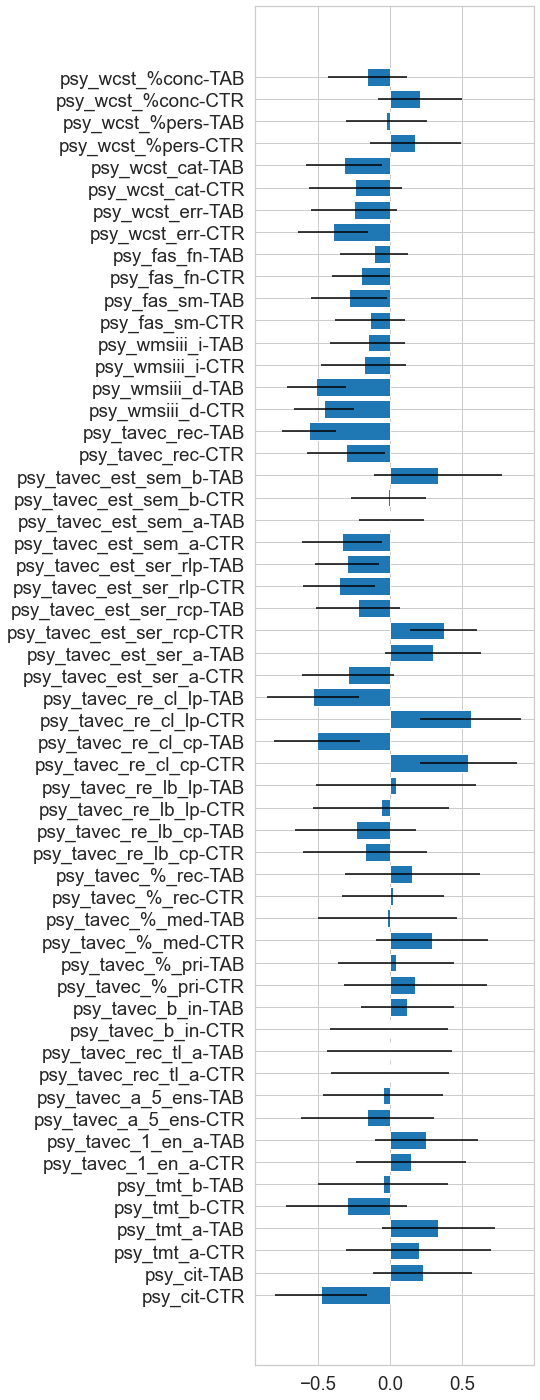

In [34]:
fig, axs = plt.subplots(1, 1, figsize=(5,25))
icx = 0
err = (pls["bootres"]["y_loadings_ci"][:, icx, 1] - pls["bootres"]["y_loadings_ci"][:, icx, 0]) / 2   
axs.barh(np.arange(len(err)), pls["y_loadings"][:, icx], xerr=err)
axs.set_yticks(np.arange(len(conditions)))#, labels=ext_pet_roi_df.columns[1:].to_numpy()[relidx])
axs.set_yticklabels(np.array(conditions)) #(ext_pet_roi_maps.columns[1:].to_numpy()[sorted_idx])

In [35]:
# Gráfico que condiciones que no pasan por cero
icx = 0
ind_sig = np.where(abs(err) < abs(pls["y_loadings"][:, icx]))[0]

new_ind = list()
for i in range(len(ind_sig)):
    if ind_sig[i] % 2 == 0: # Si el índice es par
        if i==len(ind_sig)-1:
            new_ind.insert(i+1, ind_sig[i] + 1)
            
        elif ind_sig[i] + 1 == ind_sig[i+1]: # Si los dos índices son consecutivos 
            flag = 'ok'
        else:
            new_ind.insert(i+1, ind_sig[i] + 1) # Insertar consecutivo 
            flag = 'ok'
    else: # Si el índice es impar
        if i==0:
            new_ind.insert(0, ind_sig[i] - 1) # Insertar en la primera posición
            
        elif ind_sig[i] - 1 == ind_sig[i-1]:
            flag = 'ok'
        else:
            new_ind.insert(i-1, ind_sig[i] - 1)
            #print('no')
            
new_sig = list(ind_sig) + new_ind
new_sig.sort()

color_list = ['C0','C1']

In [36]:
# Mejoras gráficos 
# no repetir etiquetas
# Incrementar el tamaño del texto
# Incluir gráficos de regiones cerebrales relacionadas con las pruebas 
# Añadir líneas de regresión a los gráficos de dispersión

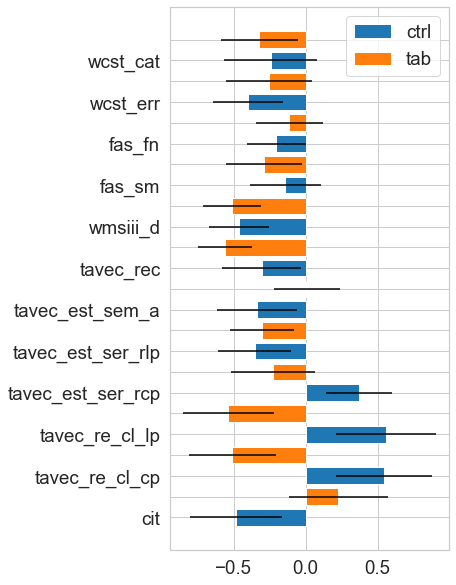

In [63]:
fig, axs = plt.subplots(1, 1, figsize=(5,10))
icx = 0
err_sig = (pls["bootres"]["y_loadings_ci"][new_sig, icx, 1] - pls["bootres"]["y_loadings_ci"][new_sig, icx, 0]) / 2   
axx= axs.barh(np.arange(len(err_sig)), pls["y_loadings"][new_sig, icx], xerr=err_sig, color=color_list)
conditions_new = [i.split('-')[0][4:] for i in conditions]
axs.set_yticks(np.arange(len(new_sig)))
labels = np.array(conditions_new)[new_sig]
labels[1::2] = ' '
axs.set_yticklabels(labels)
axs.legend(axx,['ctrl','tab'])

## Gráficos de dispersión

In [ ]:
score_pls = pd.DataFrame()
score_pls['subject'] = all_data_sorted['subject']
score_pls['group'] = all_data_sorted['group']
score_pls['psy_tavec_re_cl_lp'] = all_data_sorted['psy_tavec_re_cl_lp']
score_pls['psy_tavec_re_cl_cp'] = all_data_sorted['psy_tavec_re_cl_cp']
score_pls['x_score']=pls.x_scores[:,0]
score_pls['y_score']=pls.y_scores[:,0]

In [ ]:
# Gráfico x vs y scores
sns.set(rc={'figure.figsize':(11,8)})
g=sns.scatterplot(x="x_score", y="y_score",
                  hue="group",data=score_pls,linewidth=1, s=100)

plt.title("X SCORE VS Y SCORE LV 1")
plt.show()

In [ ]:
# Gráfico variable latente 1 vs psy_tavec_re_cl_cp (recuerdo claves a corto plazo)
sns.set(rc={'figure.figsize':(11,8)})
        
g=sns.scatterplot(x="x_score", y="psy_tavec_re_cl_cp", s=100,
                  hue="group",legend=True,data=score_pls,linewidth=1)

plt.title("X SCORE VS TAVEC_RE_CL_CP")
plt.show()

In [ ]:
# Gráfico variable latente 1 vs psy_tavec_re_cl_cp (recuerdo claves a corto plazo)
sns.set(rc={'figure.figsize':(11,8)})
        
g=sns.scatterplot(x="y_score", y="psy_tavec_re_cl_cp",s=100,
                  hue="group",legend=True,data=score_pls,linewidth=1)

plt.title("Y SCORE VS TAVEC_RE_CL_CP")
plt.show()

In [ ]:
# Gráfico variable latente 1 vs psy_tavec_re_cl_lp (recuerdo claves a largo plazo)
sns.set(rc={'figure.figsize':(11,8)})
        
g=sns.scatterplot(x="x_score", y="psy_tavec_re_cl_lp", s=100,
                  hue="group",legend=True,data=score_pls,linewidth=1)

plt.title("X SCORE VS TAVEC_RE_CL_LP")
plt.show()

In [ ]:
# Gráfico variable latente 1 vs psy_tavec_re_cl_lp (recuerdo claves a largo plazo)
sns.set(rc={'figure.figsize':(11,8)})
        
g=sns.scatterplot(x="y_score", y="psy_tavec_re_cl_lp", s=100,
                  hue="group",legend=True,data=score_pls,linewidth=1)

plt.title("Y SCORE VS TAVEC_RE_CL_LP")
plt.show()

## PLS invirtiendo X: behavior, Y: volumes

In [ ]:
# Matriz X: datos de volúmenes
Y = all_data_sorted.iloc[:,3:453].values
X = all_data_sorted[y_list].values

In [ ]:
pls2 = pyls.behavioral_pls(X, Y, groups=list_len, seed=42, n_proc='max')

In [ ]:
pvals2 = pls2.permres['pvals']
x_weights = pls2.bootres.x_weights_normed # 28 
y_weights = pls2.y_weights # 900 (450 características por grupo)
pvals2

In [ ]:
sig_ind = np.where(pvals2 < 0.05)[0]
sig_ind

In [ ]:
pls.varexp[sig_ind]

In [ ]:
conditions2 = all_data_sorted.iloc[:,3:453].columns.to_list()
#conditions2

In [ ]:
conditions = []
for j in conditions2:
    conditions = conditions + [j + '-' + i for i in groups]
#conditions

In [ ]:
# Gráfico que condiciones que no pasan por cero
icx = 0
err = (pls2["bootres"]["y_loadings_ci"][:, icx, 1] - pls2["bootres"]["y_loadings_ci"][:, icx, 0]) / 2   
ind_sig = np.where(abs(err) < abs(pls2["y_loadings"][:, icx]))[0]

color_list = ['C0','C1']

In [ ]:
new_ind = list()
for i in range(len(ind_sig)):
    if ind_sig[i] % 2 == 0: # Si el índice es par
        if i==len(ind_sig)-1:
            new_ind.insert(i+1, ind_sig[i] + 1)
            
        elif ind_sig[i] + 1 == ind_sig[i+1]: # Si los dos índices son consecutivos 
            flag = 'ok'
        else:
            new_ind.insert(i+1, ind_sig[i] + 1) # Insertar consecutivo 
            flag = 'ok'
    else: # Si el índice es impar
        if i==0:
            new_ind.insert(0, ind_sig[i] - 1) # Insertar en la primera posición
            
        elif ind_sig[i] - 1 == ind_sig[i-1]:
            flag = 'ok'
        else:
            new_ind.insert(i-1, ind_sig[i] - 1)
            #print('no')
            
new_sig = list(ind_sig) + new_ind
new_sig.sort()

In [ ]:
# División estructuras subcorticales
sub_idx = np.where(np.array(new_sig) < 100)[0]
sub_sig = np.array(new_sig)[sub_idx.astype(int)]
newfig, axs = plt.subplots(1, 1, figsize=(5,15))
err_sig = (pls2["bootres"]["y_loadings_ci"][sub_sig, icx, 1] - pls2["bootres"]["y_loadings_ci"][sub_sig, icx, 0]) / 2   
axx= axs.barh(np.arange(len(err_sig)), pls2["y_loadings"][sub_sig, icx], xerr=err_sig, color=color_list)
conditions_new = [i.split('-')[0:-1] for i in conditions]
#conditions_new = conditions
axs.set_yticks(np.arange(len(sub_sig)))
axs.set_yticklabels(np.array(conditions_new)[sub_sig])
axs.legend(axx,['ctrl','tab'])

In [ ]:
cor_idx = np.where(np.array(new_sig) > 100)[0]
cor_sig = np.array(new_sig)[cor_idx.astype(int)]
newfig, axs = plt.subplots(1, 1, figsize=(5,70))
err_sig = (pls2["bootres"]["y_loadings_ci"][cor_sig, icx, 1] - pls2["bootres"]["y_loadings_ci"][cor_sig, icx, 0]) / 2   
axx= axs.barh(np.arange(len(err_sig)), pls2["y_loadings"][cor_sig, icx], xerr=err_sig, color=color_list)
conditions_new = [i.split('-')[0] for i in conditions]
axs.set_yticks(np.arange(len(cor_sig)))
axs.set_yticklabels(np.array(conditions_new)[cor_sig])
axs.legend(axx,['ctrl','tab'])

In [ ]:
# Grafico variables que separan los gurpos
cor_sig  = [conditions.index('17Networks_RH_DorsAttnB_PostC_3-CTR'),
            conditions.index('17Networks_RH_DorsAttnB_PostC_3-TAB')]
newfig, axs = plt.subplots(1, 1, figsize=(5,3))
err_sig = (pls2["bootres"]["y_loadings_ci"][cor_sig, icx, 1] - pls2["bootres"]["y_loadings_ci"][cor_sig, icx, 0]) / 2   
axx= axs.barh(np.arange(len(err_sig)), pls2["y_loadings"][cor_sig, icx], xerr=err_sig, color=color_list)
conditions_new = [i.split('-')[0] for i in conditions]
axs.set_yticks(np.arange(len(cor_sig)))
axs.set_yticklabels(np.array(conditions_new)[cor_sig])
axs.legend(axx,['ctrl','tab'])